In [ ]:
#////////////////variables to set/////////////////////////
# /!\
#/_!_\ to change according to computer

#main path to data, change according to environment
root_dir = r'E:\Users\Dylan\Desktop\UdeM_H22\E_PSY3008\data_desmartaux\Nii'
dir_to_save = r'C:\Users\Dylan\Desktop\UdeM_E22\Projet_Ivado_rainvillelab\results_GLM\testing_scripts'

#SERVEUR elm

#root_dir = r'/data/rainville/dylan_projet_ivado_decodage/Nii'
#dir_to_save = r'/data/rainville/dylan_projet_ivado_decodage/results/GLM_1st_level_each_shock'

# /!\
#/_!_\ to change according to computer
#local
timestamps_root_path = r'C:\Users\Dylan\Desktop\BAC_neurocog\UM_H22\PSY3008\times_stamps'

 #elm
#timestamps_path_root = r'/data/rainville/dylan_projet_ivado_decodage/time_stamps'
many_runs=True

In [ ]:
import numpy as np
import os
import pandas as pd
import glob
import nibabel as nib
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
from A_data_prep import function_code as A_data_prep
from B_design_matrix import function_DM as B_design_matrix
from C_contrasts import function_contrasts as contrast

In [ ]:
#==============================================================
#store all subject's name in a list
ls_subj_name = [subject for subject in os.listdir(root_dir)]

#make a list for all the subject's path to data
ls_subj_path  = [os.path.join(root_dir,subject) for subject in os.listdir(root_dir)]


for subj_path in ls_subj_path:

    #=================
    subj_name = os.path.basename(os.path.normpath(subj_path)) #extract last part of subj_path to get subject's name
    print(subj_name + ' = subj_name')
    #----path preparation---
    #res_folder = input('Enter the name under which to create ')
    #Creating a dir to save, only if it doesn't exists
    if os.path.exists(os.path.join(dir_to_save,subj_name)) is False:

        os.mkdir(os.path.join(dir_to_save,subj_name))
    else :
        pass
    #=================
    #looking for the regressors' file, which starts with 'APM' and read it as csv
    movement_reg_name = [i for i in os.listdir(subj_path) if i.startswith('APM')]
    mvmnt_reg_path = os.path.join(subj_path,movement_reg_name[0])#movement_reg_name[0] because there's only one item in the list
    df_mvmnt_reg_full = pd.read_csv(mvmnt_reg_path, sep= '\s+', header=None)#full because we'll split it later according to condition

    #=================
    #file names that contains the fMRI volumes.
    str_analgesia ='Analgesia'
    str_hyper = 'Hyperalgesia'

    if many_runs:
        design_matrices = []
        all_fmri_timeseries = []


In [ ]:
 #Main loop that will go over the condition's file, and generate a design matrix (DM) and a contrast according to the condition
    #In that loop, a Timestamps,a DM name,a mouvement regressors dataframe, a DM and statistical maps will be generated and saved
    for condition_file in [i for i in os.listdir(subj_path) if str_analgesia in i or str_hyper in i ]:
        print(condition_file + ' = condition_file')

        #-------Extracting fMRI volumes-------
        data_path = os.path.join(subj_path,condition_file) #path to the data such as : /subj_01/02-Analgesia/<all nii files>
        subj_volumes= glob.glob(os.path.join(data_path,'sw*'))#extracting all the nii files that start with sw
        print('{} NII files in path {} for subject {}'.format(len(subj_volumes),data_path,subj_name))
        print('lenght of movement regesssor df : {}'.format(len(df_mvmnt_reg_full)))

        #-------Extracting timestamps--------
        timestamps = A_data_prep.get_timestamps(data_path, subj_name,timestamps_root_path,return_df =True)
        timestamps.sort_values(by=['onset'])

        #----condition and design matrix name-----
        condition, DM_name = A_data_prep.if_str_in_file(condition_file,subj_name)#checks if str_analgesia or str_hyper is in condition_file

        #-------movement regessors--------
        if condition == 'HYPO':
             mvmnt_reg_df = A_data_prep.split_reg_upper(df_mvmnt_reg_full,len(subj_volumes))
        elif condition == 'HYPER':
            mvmnt_reg_df = A_data_prep.split_reg_lower(df_mvmnt_reg_full,len(subj_volumes)) #splitting either the first half or lower half of the mvmnt regressor df according to condition (analg/hyper)

        #------DESIGN MATRIX------
        if os.path.exists(os.path.join(dir_to_save, subj_name, DM_name)) is False:#check if the DM already exists in path to we save computing time

            design_matrix, fmri_time_series = B_design_matrix.create_DM(subj_volumes, timestamps, DM_name, mvmnt_reg_df)

            #----------SAVING OUTPUTS------------
            #saving design_matrix and time series
            design_matrix.to_csv(os.path.join(dir_to_save,subj_name,DM_name), index = False)
            fmri_img_name = subj_name + '_' + condition + '_fmri_time_series.nii'
            nib.save(fmri_time_series, os.path.join(dir_to_save,subj_name,fmri_img_name))

        else:
            print('Design matrix in condition _{}_  is already existant for : {} '.format(condition, subj_name))
            design_matrix = pd.read_csv(os.path.join(dir_to_save, subj_name, DM_name))
            fmri_img_name = subj_name + '_' + condition + '_fmri_time_series.nii'
            fmri_time_series = nib.load(os.path.join(dir_to_save,subj_name, fmri_img_name))

        #-------Plot option-------
        #Uncomment to plot the design matrix as it's generated
        #from nilearn.plotting import plot_design_matrix
        #plot_design_matrix(design_matrix)
        #plt.show()

        #-------CONTRAST-------
        done_file_name = 'done_contrast_' + condition + '.txt' #define a done_file name to check if it  already exists in file

        if many_runs: #if many runs, the contrast function is delayed out of this for loop to append the DM and time series for all runs
            design_matrices.append(design_matrix)
            all_fmri_timeseries.append(fmri_time_series)
            condition = 'combined_runs'
        elif os.path.exists(os.path.join(dir_to_save,subj_name,done_file_name)) == False : #if done_file doesn't exist

            #contrast for a single shock activation map
            #beta_map = contrast.glm_contrast_1event(design_matrix, os.path.join(dir_to_save,subj_name), subj_name, fmri_time_series, run = condition)

            #contrast for all shocks activation map, one for each design matrix will be made
            beta_map = contrast.glm_contrast_all_shocks(design_matrix, os.path.join(dir_to_save,subj_name), subj_name, fmri_time_series, run = condition)

            #-------SAVING-------
            #write done_contrast_hyper/hypo to keep track of what has been computed
            save_done_file(os.path.join(dir_to_save,subj_name,done_file_name))

        else:
            print('Contrast : _{}_ has already been done for subject : {} '.format(condition, subj_name))

    if many_runs:

        beta_map = contrast.glm_contrast_runs_N_shocks(design_matrices,all_fmri_timeseries, os.path.join(dir_to_save,subj_name), subj_name, run_name = condition)
        done_file_name = 'done_contrast_' + condition + '.txt'
        contrast.save_done_file(os.path.join(dir_to_save,subj_name,done_file_name))


APM_02_H2 = subj_name
02-Hyperalgesia = condition_file
388 NII files in path E:\Users\Dylan\Desktop\UdeM_H22\E_PSY3008\data_desmartaux\Nii\APM_02_H2\02-Hyperalgesia for subject APM_02_H2
lenght of movement regesssor df : 760
Design matrix in condition _HYPER_  is already existant for : APM_02_H2 
03-Analgesia = condition_file
372 NII files in path E:\Users\Dylan\Desktop\UdeM_H22\E_PSY3008\data_desmartaux\Nii\APM_02_H2\03-Analgesia for subject APM_02_H2
lenght of movement regesssor df : 760
Design matrix in condition _HYPO_  is already existant for : APM_02_H2 
COMPUTING GLM for all the runs, for subject APM_02_H2


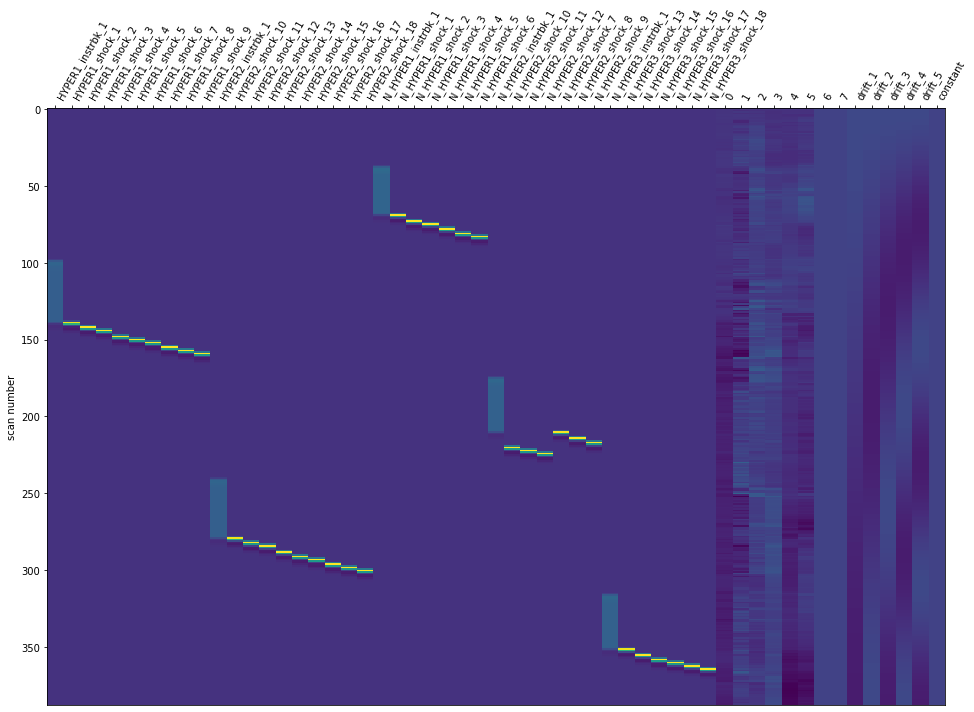

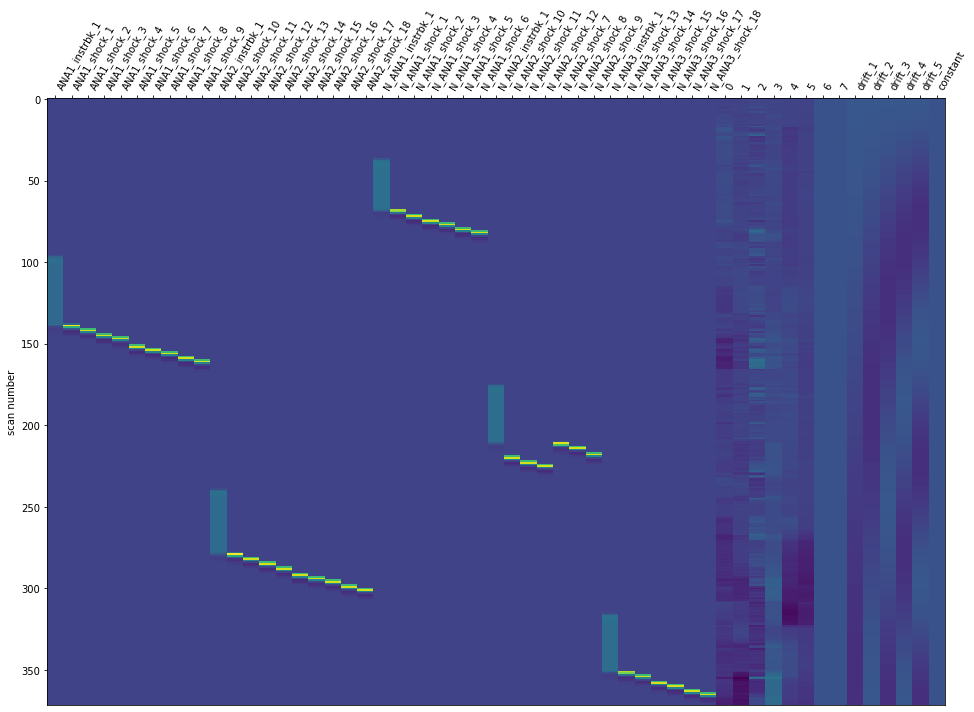

FirstLevelModel(high_pass=0.00233645, hrf_model='spm', t_r=3)
will add  ANA1_shock_1
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_2
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_3
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_4
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_5
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_6
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_7
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_shock_8
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True
will add  ANA1_sho

C:\Users\Dylan\AppData\Roaming\Python\Python310\site-packages\nilearn\glm\first_level\first_level.py:657: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


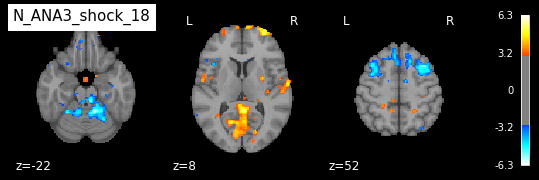

Have saved beta_map as a : <class 'nibabel.nifti1.Nifti1Image'> , having shape : (91, 109, 91) , under name : beta_map_APM_02_H2_combined_runs_Neut_shocks


AttributeError: module 'C_contrasts.function_contrasts' has no attribute 'save_done_file'

In [2]:
import main_script_1st_level

In [9]:
keys = 'N_Ana_shock'

        #if the key is str, in order to exclude the drifts and other parameters
if type(keys) is str:

    ls_string_interest = ['N', 'shock']
    word1 = 'N'
    word2 = 'shock'
    if word1 in keys and word2 in keys:
        print('will add ', keys)
        print('because ls_string_interest[0] is in keys',ls_string_interest[0] in keys)
        print('because ls_string_interest[1] is in keys',ls_string_interest[1] in keys)

    else:
        print('no')#in the contrast vector for all regressors of interest
        

will add  N_Ana_shock
because ls_string_interest[0] is in keys True
because ls_string_interest[1] is in keys True


In [ ]:
 actual_key_name = key_list[indx]
                ls_keys.append(keys)#extract the actual regressor/key name with the index position
                contrast_vector += identity_matrix[:, indx] #sum of the contrast vector with the identity matrix column to stack the ones
                 

<div class="alert alert-info">
<h1>Testing two way of computing contrast from Nilearn example </h2>
</div>

## testing multiplecond files from Kunz et al.

### extraire les fichiers .mat et les convrtir en pandas dataframe

In [15]:
import scipy.io
import os

path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\PHASIC\Multiconds_files'

timestamps = scipy.io.loadmat(os.path.join(path, 'KunzStudy1_TxT_cond_pain_block.mat'),simplify_cells =True)
                              

In [17]:
timestamps


{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Apr  7 23:01:24 2017',
 '__version__': '1.0',
 '__globals__': [],
 'names': array(['painbk_1', 'painbk_2', 'painbk_3', 'painbk_4', 'painbk_5',
        'painbk_6', 'painbk_7', 'painbk_8'], dtype=object),
 'onsets': array([31.463, 62.788, 125.438, 219.412, 282.062, 313.406, 376.055,
        471.407], dtype=object),
 'durations': array([10, 10, 10, 10, 10, 10, 10, 10], dtype=object)}

In [18]:
df_timestamps = pd.concat([pd.DataFrame(timestamps['onsets']),pd.DataFrame(timestamps['durations']),pd.DataFrame(timestamps['names'])], axis = 1)
df_timestamps.columns = ['onset', 'duration','trial_type']

## Import SPM design matrices with nilearn

In [2]:
dm_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\TxT_SPM_MAT_Files\APM_02_H2\SPM.mat'

In [6]:
import scipy.io
import os
DM_mat = scipy.io.loadmat(os.path.join(dm_path),simplify_cells =True)

In [7]:
DM_mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Jul  7 15:55:43 2020',
 '__version__': '1.0',
 '__globals__': [],
 'SPM': {'xY': {'RT': 3,
   'P': array(['/Volumes/RainvilleMac_EHD/IMAGING_DATA2/fMRI/ASTREFF/fMRI_Analysis/Model#3/Nii_despiked_subj_artbadvol/diffTS/APM_02_H2/03-Analgesia/swdvraf201212051400-0007-00001-000001-01.nii   ',
          '/Volumes/RainvilleMac_EHD/IMAGING_DATA2/fMRI/ASTREFF/fMRI_Analysis/Model#3/Nii_despiked_subj_artbadvol/diffTS/APM_02_H2/03-Analgesia/swdvraf201212051400-0007-00002-000002-01.nii   ',
          '/Volumes/RainvilleMac_EHD/IMAGING_DATA2/fMRI/ASTREFF/fMRI_Analysis/Model#3/Nii_despiked_subj_artbadvol/diffTS/APM_02_H2/03-Analgesia/swdvraf201212051400-0007-00003-000003-01.nii   ',
          '/Volumes/RainvilleMac_EHD/IMAGING_DATA2/fMRI/ASTREFF/fMRI_Analysis/Model#3/Nii_despiked_subj_artbadvol/diffTS/APM_02_H2/03-Analgesia/swdvraf201212051400-0007-00004-000004-01.nii   ',
          '/Volumes/RainvilleMac_EHD/IMAGING_DATA2/fMRI/

In [6]:
import nipype

In [7]:
import importlib
importlib.reload(nipype)

<module 'nipype' from 'C:\\Users\\Dylan\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\nipype\\__init__.py'>

In [12]:
import nipype.interfaces.spm as spm
est = spm.EstimateModel()
est.inputs.spm_mat_file = dm_path
est.inputs.estimation_method = {'Classical': 1}
est.run()

OSError: This docstring was not generated by Nipype!


## SPM design matrix testing

In [15]:
import pandas as pd
import glob 
from nilearn.image import concat_imgs
import nibabel as nib

In [13]:
import os

# creating saving path for matlab script
    dir = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\TxT_SPM_MAT_Files'
out = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_all_runs'

for folder in os.listdir(dir):
    if 'APM' in folder:
    
        os.mkdir(os.path.join(out,folder))

IndentationError: unexpected indent (742397069.py, line 4)

In [14]:
path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_csv'
save_path = out
nii_path = r'E:\Users\Dylan\Desktop\UdeM_H22\E_PSY3008\data_desmartaux\Nii'


NameError: name 'out' is not defined

In [118]:

for subject in os.listdir(path):
    
    #SPM dm and event extraction
    subj_path = os.path.join(path,subject)
    events = (pd.read_csv(os.path.join(subj_path, os.listdir(subj_path)[1]))) #read event, should change [index] according to folder
    
    csv = pd.read_csv(os.path.join(subj_path, os.listdir(subj_path)[0]))
    print(csv)
    design_matrix= pd.DataFrame()#read DM.csv
    design_matrix.columns = events.columns
    
    #extract and concat fmri data files
    subj_data_path = os.path.join(nii_path,subject)  
    print(subj_data_path)
    subj_volumes = glob.glob(os.path.join(subj_data_path,'*','sw*'))
    print(len(subj_volumes))
    
    fmri_time_series = concat_imgs(subj_volumes)
    #save
    print(design_matrix.shape)
    print(fmri_time_series.shape)
    DM_name = 'DM_SPM_Hyper_Hypo.pkl'
    design_matrix.to_pickle(os.path.join(save_path,subject, DM_name))
    fmri_name = 'fmri_4D_concat_all_runs'
    nib.save(fmri_time_series, os.path.join(save_path,subject,fmri_name))
    print('done saving for ' + subject)

       0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...     0.82      0.83  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00000  0.000000   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00000  0.000000   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00000  0.000000   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00000  0.000000   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00000  0.000000   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...      ...       ...   
754  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.24243  0.032585   
755  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.27500 -0.000676   
756  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.30320  0.012239   
757  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.30802 -0.032072   
758  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.32327  0.047076   

        0.84      0.85     

ValueError: Length mismatch: Expected axis has 0 elements, new values have 100 elements

<AxesSubplot:label='conditions', ylabel='scan number'>

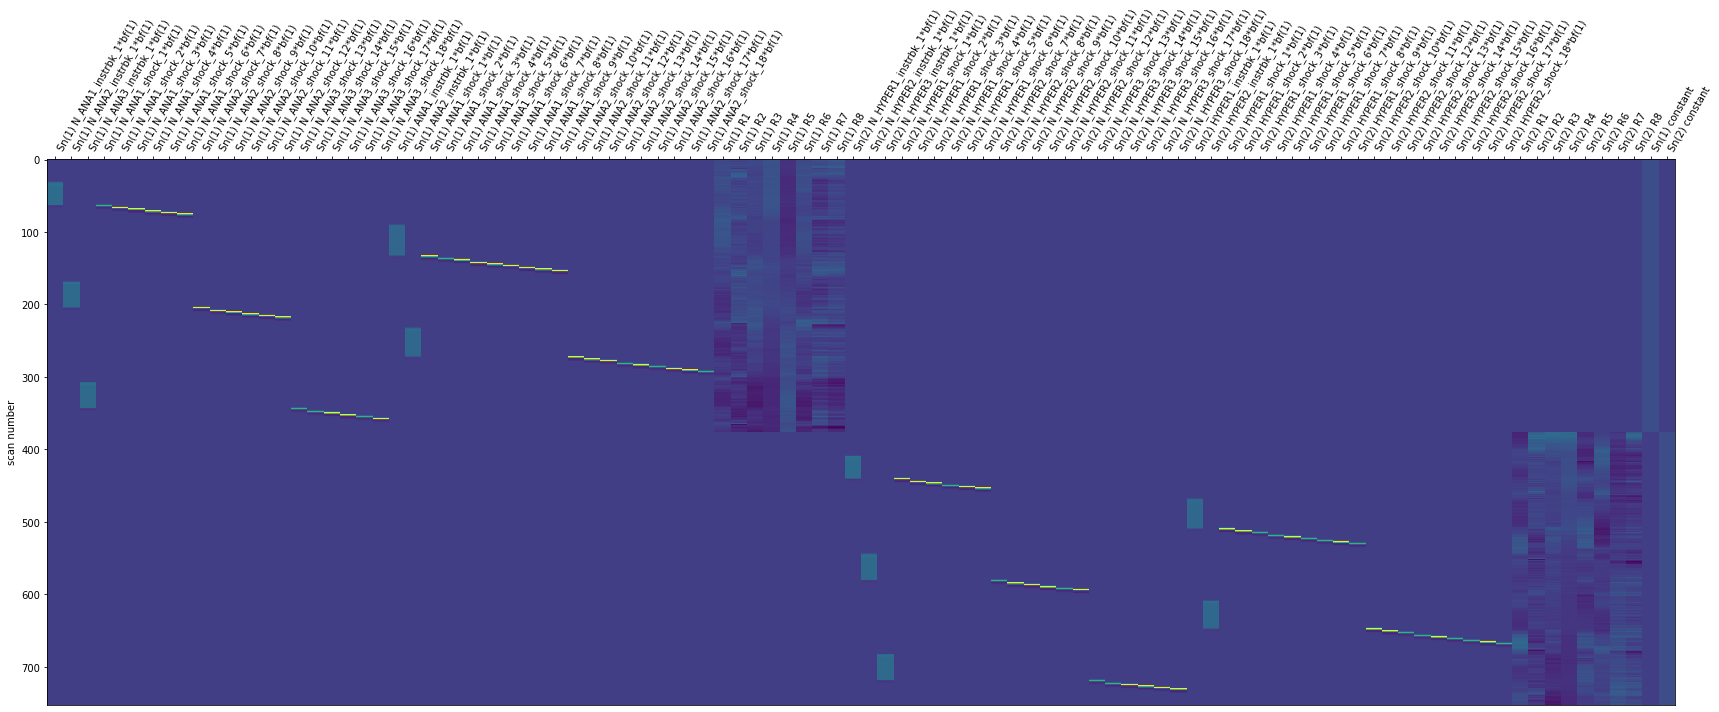

In [45]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)


In [1]:
nii_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_all_runs\APM_02_H2\fmri_4D_concat_all_runs.nii'

In [6]:
import nibabel as nib
imgs = nib.load(nii_path)


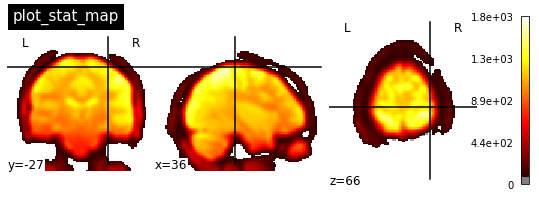

In [11]:
from nilearn import plotting
from nilearn.image import mean_img
# Visualizing t-map image on EPI template with manual
# positioning of coordinates using cut_coords given as a list
plotting.plot_stat_map(mean_img(imgs),
                       threshold=100, title="plot_stat_map",
                       cut_coords=[36, -27, 66])

In [8]:
def load_pkl_to_pd(ls_pkl_paths):
    #--load design matrices from pkl to pandas-----
    ls_pandas = []
    for i in range(len(ls_pkl_paths)):
        tmp = pd.read_pickle(ls_pkl_paths[i])
        ls_pandas.append(tmp)

    return ls_pandas

In [107]:
subj_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_all_runs\APM_03_H1\DM_SPM_Hyper_Hypo.csv'
#events = (pd.read_csv(os.path.join(subj_path, os.listdir(subj_path)[1]))) #read event, should change [index] according to folder
import os   
csv = pd.read_csv(subj_path,index_col = [0])
csv

Sn(1) N_ANA1_instrbk_1*bf(1)  Sn(1) N_ANA2_instrbk_1*bf(1)  \
0                             0.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             0.0                           0.0   
4                             0.0                           0.0   
..                            ...                           ...   
739                           0.0                           0.0   
740                           0.0                           0.0   
741                           0.0                           0.0   
742                           0.0                           0.0   
743                           0.0                           0.0   

     Sn(1) N_ANA3_instrbk_1*bf(1)  Sn(1) N_ANA1_shock_1*bf(1)  \
0                             0.0                         0.0   
1                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
..                            ...                         ...   
739                           0.0                         0.0   
740                           0.0                         0.0   
741                           0.0                         0.0   
742                           0.0                         0.0   
743                           0.0                         0.0   

     Sn(1) N_ANA1_shock_2*bf(1)  Sn(1) N_ANA1_shock_3*bf(1)  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
..                          ...                         ...   
739                         0.0                         0.0   
740                         0.0                         0.0   
741                         0.0                         0.0   
742                         0.0                         0.0   
743                         0.0                         0.0   

     Sn(1) N_ANA1_shock_4*bf(1)  Sn(1) N_ANA1_shock_5*bf(1)  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
..                          ...                         ...   
739                         0.0                         0.0   
740                         0.0                         0.0   
741                         0.0                         0.0   
742                         0.0                         0.0   
743                         0.0                         0.0   

     Sn(1) N_ANA1_shock_6*bf(1)  Sn(1) N_ANA2_shock_7*bf(1)  ...  Sn(2) R1  \
0                           0.0                         0.0  ...  0.000000   
1                           0.0                         0.0  ...  0.000000   
2                           0.0                         0.0  ...  0.000000   
3                           0.0                         0.0  ...  0.000000   
4                           0.0                         0.0  ...  0.000000   
..                          ...                         ...  ...       ...   
739                         0.0                         0.0  ...  0.039385   
740                         0.0                         0.0  ...  0.033708   
741                         0.0                         0.0  ...  0.047123   
742                         0.0                         0.0  ...  0.054893   
743                         0.0                

### Testing GLM 

In [11]:
import os
pkl_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_all_runs'
subj_name = r'APM_03_H1'
paths_design_matrices = glob.glob(os.path.join(pkl_path, subj_name,'DM*pkl'))
print(paths_design_matrices)
design_matrices = load_pkl_to_pd(paths_design_matrices)
design_matrices[0]


['C:\\Users\\Dylan\\Desktop\\UM_Bsc_neurocog\\E22\\Projet_Ivado_rainvillelab\\results_GLM\\SPM_DM_single_event_all_runs\\APM_03_H1\\DM_SPM_Hyper_Hypo.pkl']


Sn(1) N_ANA1_instrbk_1*bf(1)  Sn(1) N_ANA2_instrbk_1*bf(1)  \
0                             0.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             0.0                           0.0   
4                             0.0                           0.0   
..                            ...                           ...   
739                           0.0                           0.0   
740                           0.0                           0.0   
741                           0.0                           0.0   
742                           0.0                           0.0   
743                           0.0                           0.0   

     Sn(1) N_ANA3_instrbk_1*bf(1)  Sn(1) N_ANA1_shock_1*bf(1)  \
0                             0.0                         0.0   
1                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
..                            ...                         ...   
739                           0.0                         0.0   
740                           0.0                         0.0   
741                           0.0                         0.0   
742                           0.0                         0.0   
743                           0.0                         0.0   

     Sn(1) N_ANA1_shock_2*bf(1)  Sn(1) N_ANA1_shock_3*bf(1)  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
..                          ...                         ...   
739                         0.0                         0.0   
740                         0.0                         0.0   
741                         0.0                         0.0   
742                         0.0                         0.0   
743                         0.0                         0.0   

     Sn(1) N_ANA1_shock_4*bf(1)  Sn(1) N_ANA1_shock_5*bf(1)  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
..                          ...                         ...   
739                         0.0                         0.0   
740                         0.0                         0.0   
741                         0.0                         0.0   
742                         0.0                         0.0   
743                         0.0                         0.0   

     Sn(1) N_ANA1_shock_6*bf(1)  Sn(1) N_ANA2_shock_7*bf(1)  ...  Sn(2) R1  \
0                           0.0                         0.0  ...  0.000000   
1                           0.0                         0.0  ...  0.000000   
2                           0.0                         0.0  ...  0.000000   
3                           0.0                         0.0  ...  0.000000   
4                           0.0                         0.0  ...  0.000000   
..                          ...                         ...  ...       ...   
739                         0.0                         0.0  ...  0.039385   
740                         0.0                         0.0  ...  0.033708   
741                         0.0                         0.0  ...  0.047123   
742                         0.0                         0.0  ...  0.054893   
743                         0.0                

In [12]:
paths_img = glob.glob(os.path.join(pkl_path, subj_name,'fmri*'))
paths_img

['C:\\Users\\Dylan\\Desktop\\UM_Bsc_neurocog\\E22\\Projet_Ivado_rainvillelab\\results_GLM\\SPM_DM_single_event_all_runs\\APM_03_H1\\fmri_4D_concat_all_runs.nii']

In [13]:
imgs = nib.load(paths_img[0])
imgs.shape

(91, 109, 91, 744)

In [14]:
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs, mean_img
import nibabel as nib
from nilearn.plotting import plot_design_matrix
fmri_glm = FirstLevelModel(t_r=3,
                               noise_model='ar1',
                               standardize=False,
                               slice_time_ref = 0.5,
                               hrf_model='spm',
                               drift_model='cosine',
                               high_pass= 0.00233645)

In [ ]:
fmri_glm.fit(paths_img, design_matrices = design_matrices[0])

In [ ]:
contrast_vector = []
beta_map = fmri_glm.compute_contrast(
         contrast_vector, stat_type = 't', output_type= output_type)

In [ ]:
for subject in os.listdir(path):
    
    #SPM dm and event extraction
    subj_path = os.path.join(path,subject)
    
    
    
    +v = pd.read_csv(os.path.join(subj_path, os.listdir(subj_path)[0]))
    print(csv)
    design_matrix= pd.DataFrame()#read DM.csv
    design_matrix.columns = events.columns
    
    #extract and concat fmri data files
    subj_data_path = os.path.join(nii_path,subject)  
    print(subj_data_path)
    subj_volumes = glob.glob(os.path.join(subj_data_path,'*','sw*'))
    print(len(subj_volumes))
    
    
    
    
    
    

## Correlation between SPM and nilearn design_matrices

In [81]:
import os
import glob
import numpy as np

In [92]:
SPM_dir = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_all_runs'
py_dir = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_all_runs'

In [46]:
spm_dir = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_all_runs'
py_dir = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results_GLM\SPM_DM_single_event_all_runs'

In [93]:
#get subject's path in list
ls_subj_spm = glob.glob(os.path.join(SPM_dir,'*'))
ls_subj_py = glob.glob(os.path.join(SPM_dir,'*'))

#sort both lists
ls_subj_spm.sort(reverse=True)
ls_subj_spm.sort()
ls_subj_py.sort(reverse=True)
ls_subj_py.sort()

In [94]:
#check if subject from both lists match when they are being compared index by index
idx = 0
for sub in ls_subj_spm:
    
    subj_id_spm = os.path.basename(os.path.normpath(sub))
    subj_id_py = os.path.basename(os.path.normpath(ls_subj_py[idx]))
    if subj_id_spm != subj_id_py:
        print(subj_id)
        print(ls_subj_py[idx])
        print('mismatch between participants at index : ' + idx)
    idx += 1

In [132]:
#extract DM from both subj_path
for spm_subj_dir, py_subj_dir in zip(ls_subj_spm, ls_subj_py):

    #check if subjects are the same
    if os.path.basename(
        os.path.normpath(spm_subj_dir))!= os.path.basename(os.path.normpath(py_subj_dir)):
        print('mismatch between participants at subject : '+ subj_spmj)
        
    #load spm DM
    spm_dm_dir = glob.glob(os.path.join(spm_subj_dir,'DM*csv'))#get path of DM
    spm_dm = pd.read_csv(spm_dm_dir[0],index_col = [0])
    #load py DM
    py_dm_dir = glob.glob(os.path.join(spm_subj_dir,'DM*csv'))#get path of DM
    py_dm = pd.read_csv(spm_dm_dir[0],index_col = [0])
    
    #correlation between both
    size = [spm_dm.shape, py_dm.shape]
    out_array = np.corrcoef(spm_dm,py_dm)
    dot_res = py_dm.dot(spm_dm)

ValueError: matrices are not aligned

In [133]:
spm_dm


Sn(1) N_ANA1_instrbk_1*bf(1)  Sn(1) N_ANA2_instrbk_1*bf(1)  \
0                             0.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             0.0                           0.0   
4                             0.0                           0.0   
..                            ...                           ...   
755                           0.0                           0.0   
756                           0.0                           0.0   
757                           0.0                           0.0   
758                           0.0                           0.0   
759                           0.0                           0.0   

     Sn(1) N_ANA3_instrbk_1*bf(1)  Sn(1) N_ANA1_shock_1*bf(1)  \
0                             0.0                         0.0   
1                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
..                            ...                         ...   
755                           0.0                         0.0   
756                           0.0                         0.0   
757                           0.0                         0.0   
758                           0.0                         0.0   
759                           0.0                         0.0   

     Sn(1) N_ANA1_shock_2*bf(1)  Sn(1) N_ANA1_shock_3*bf(1)  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
..                          ...                         ...   
755                         0.0                         0.0   
756                         0.0                         0.0   
757                         0.0                         0.0   
758                         0.0                         0.0   
759                         0.0                         0.0   

     Sn(1) N_ANA1_shock_4*bf(1)  Sn(1) N_ANA1_shock_5*bf(1)  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
..                          ...                         ...   
755                         0.0                         0.0   
756                         0.0                         0.0   
757                         0.0                         0.0   
758                         0.0                         0.0   
759                         0.0                         0.0   

     Sn(1) N_ANA1_shock_6*bf(1)  Sn(1) N_ANA2_shock_7*bf(1)  ...  Sn(2) R1  \
0                           0.0                         0.0  ...  0.000000   
1                           0.0                         0.0  ...  0.000000   
2                           0.0                         0.0  ...  0.000000   
3                           0.0                         0.0  ...  0.000000   
4                           0.0                         0.0  ...  0.000000   
..                          ...                         ...  ...       ...   
755                         0.0                         0.0  ... -0.242426   
756                         0.0                         0.0  ... -0.274999   
757                         0.0                         0.0  ... -0.303198   
758                         0.0                         0.0  ... -0.308022   
759                         0.0                

In [131]:
dot_res

0          1          2          3          4          5    \
0    56.497055  45.395490  56.671515  46.398667  37.492569  34.543032   
1    45.395490  36.803525  45.915192  37.529395  30.253437  27.866663   
2    56.671515  45.915192  57.350394  46.821025  37.685348  34.688363   
3    46.398667  37.529395  46.821025  38.293864  30.896741  28.463884   
4    37.492569  30.253437  37.685348  30.896741  25.009947  23.065808   
..         ...        ...        ...        ...        ...        ...   
749   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
750   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
751   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
752   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
753   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

           6          7          8          9    ...        744        745  \
0    43.342843  30.570009  33.428712  40.437003  ...   0.000000   0.000000   
1    35.055418  24.520137  27.034460  32.556303  ...   0.000000   0.000000   
2    43.716420  30.481592  33.648676  40.569512  ...   0.000000   0.000000   
3    35.772464  25.090250  27.595759  33.267132  ...   0.000000   0.000000   
4    28.881447  20.417783  22.345540  26.935027  ...   0.000000   0.000000   
..         ...        ...        ...        ...  ...        ...        ...   
749   0.000000   0.000000   0.000000   0.000000  ...  21.944765  22.038730   
750   0.000000   0.000000   0.000000   0.000000  ...  19.109230  19.158858   
751   0.000000   0.000000   0.000000   0.000000  ...  22.806291  22.833640   
752   0.000000   0.000000   0.000000   0.000000  ...  31.035373  31.307515   
753   0.000000   0.000000   0.000000   0.000000  ...  27.288132  27.515963   

           746        747        748        749        750        751  \
0     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
..         ...        ...        ...        ...        ...        ...   
749  22.156782  35.012225  37.854158  26.867610  23.019838  27.053576   
750  19.238639  29.904201  32.210123  23.019838  19.790127  23.286398   
751  22.907587  35.167933  37.738295  27.053576  23.286398  27.528252   
752  31.574458  52.032769  56.792812  39.656166  33.703120  39.439910   
753  27.738680  45.483582  49.599322  34.712700  29.537400  34.559488   

           752        753  
0     0.000000   0.000000  
1     0.000000   0.000000  
2     0.000000   0.000000  
3     0.000000   0.000000  
4     0.000000   0.000000  
..         ...        ...  
749  39.656166  34.712700  
750  33.703120  29.537400  
751  39.439910  34.559488  
752  59.675880  52.099683  
753  52.099683  45.510315  

[754 rows x 754 columns]

In [130]:
dot_res.shape

(754, 754)

In [118]:
np.matmul(spm_dm,py_dm.T).shape

C:\Users\Dylan\AppData\Local\Temp\ipykernel_711772\946557824.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  np.matmul(spm_dm,py_dm.T).shape


(754, 754)

In [100]:
out_array.shape

(1508, 1508)

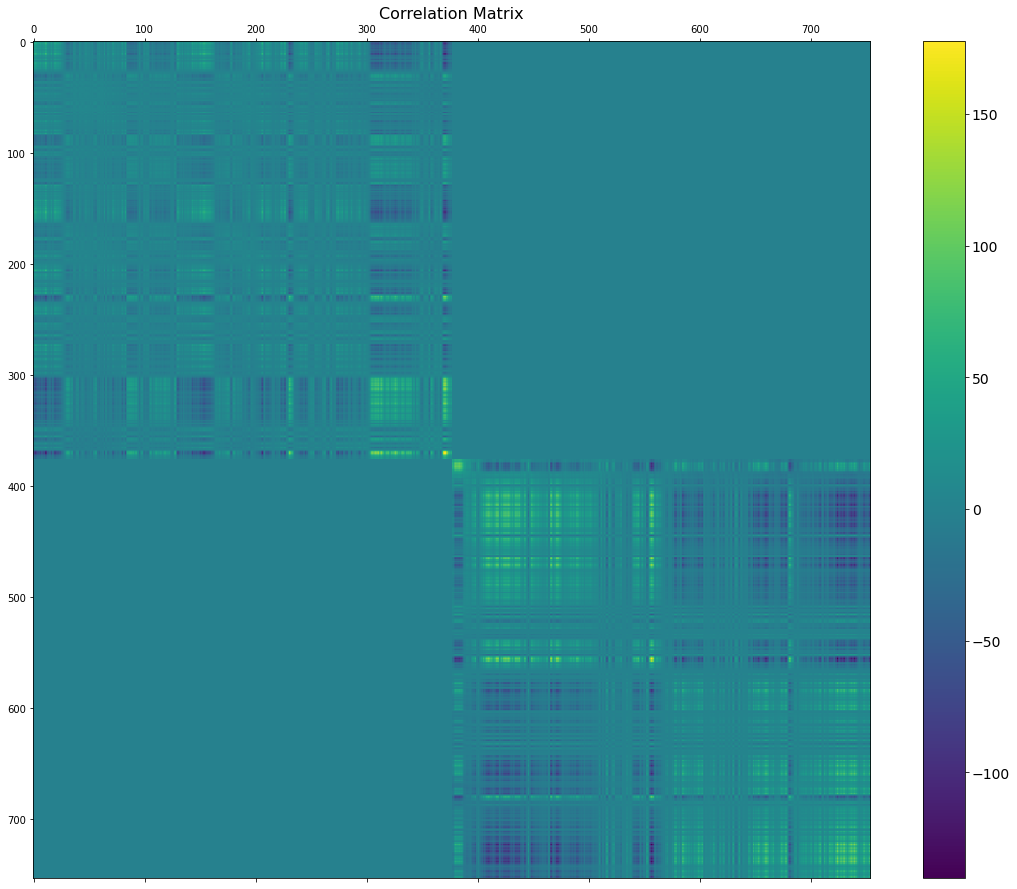

In [112]:
import matplotlib.pyplot as plt
#plot correl matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(dot_res, fignum=f.number)
#plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
#plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);